# Autonomous car classification

## Part I

Specs are that the car is supposed to recognize any moving object on the road. Especially:

* airplane
* automobile
* bird
* cat
* deer
* dog
* frog
* horse
* ship
* truck

Perfectly enough, [cifar10](https://www.cs.toronto.edu/~kriz/cifar.html) dataset is exactly the type of dataset we are looking for.

Therefore, we are going to:

* Train a Deep Learning algorithm that will be able to classify each photo in this dataset
* You will need to do it in a distributed manner using Kaggle for exemple.

In [3]:
!nvidia-smi

Fri Jun 14 23:23:36 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import necessary libraries

In [4]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm

## Define transformations for the CIFAR-10 dataset (only normalisation)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

The goal is to obtain tensors representing the image with inner values between 0 and 1.

## CIFAR-10 Loading and datasets setup

In [6]:
# Load CIFAR-10 dataset
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Training 0.8 | Validation 0.2
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])

100%|██████████| 170498071/170498071 [00:01<00:00, 106250302.34it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))

Train dataset size: 40000
Validation dataset size: 10000
Test dataset size: 10000


Let's display some images of the dataset

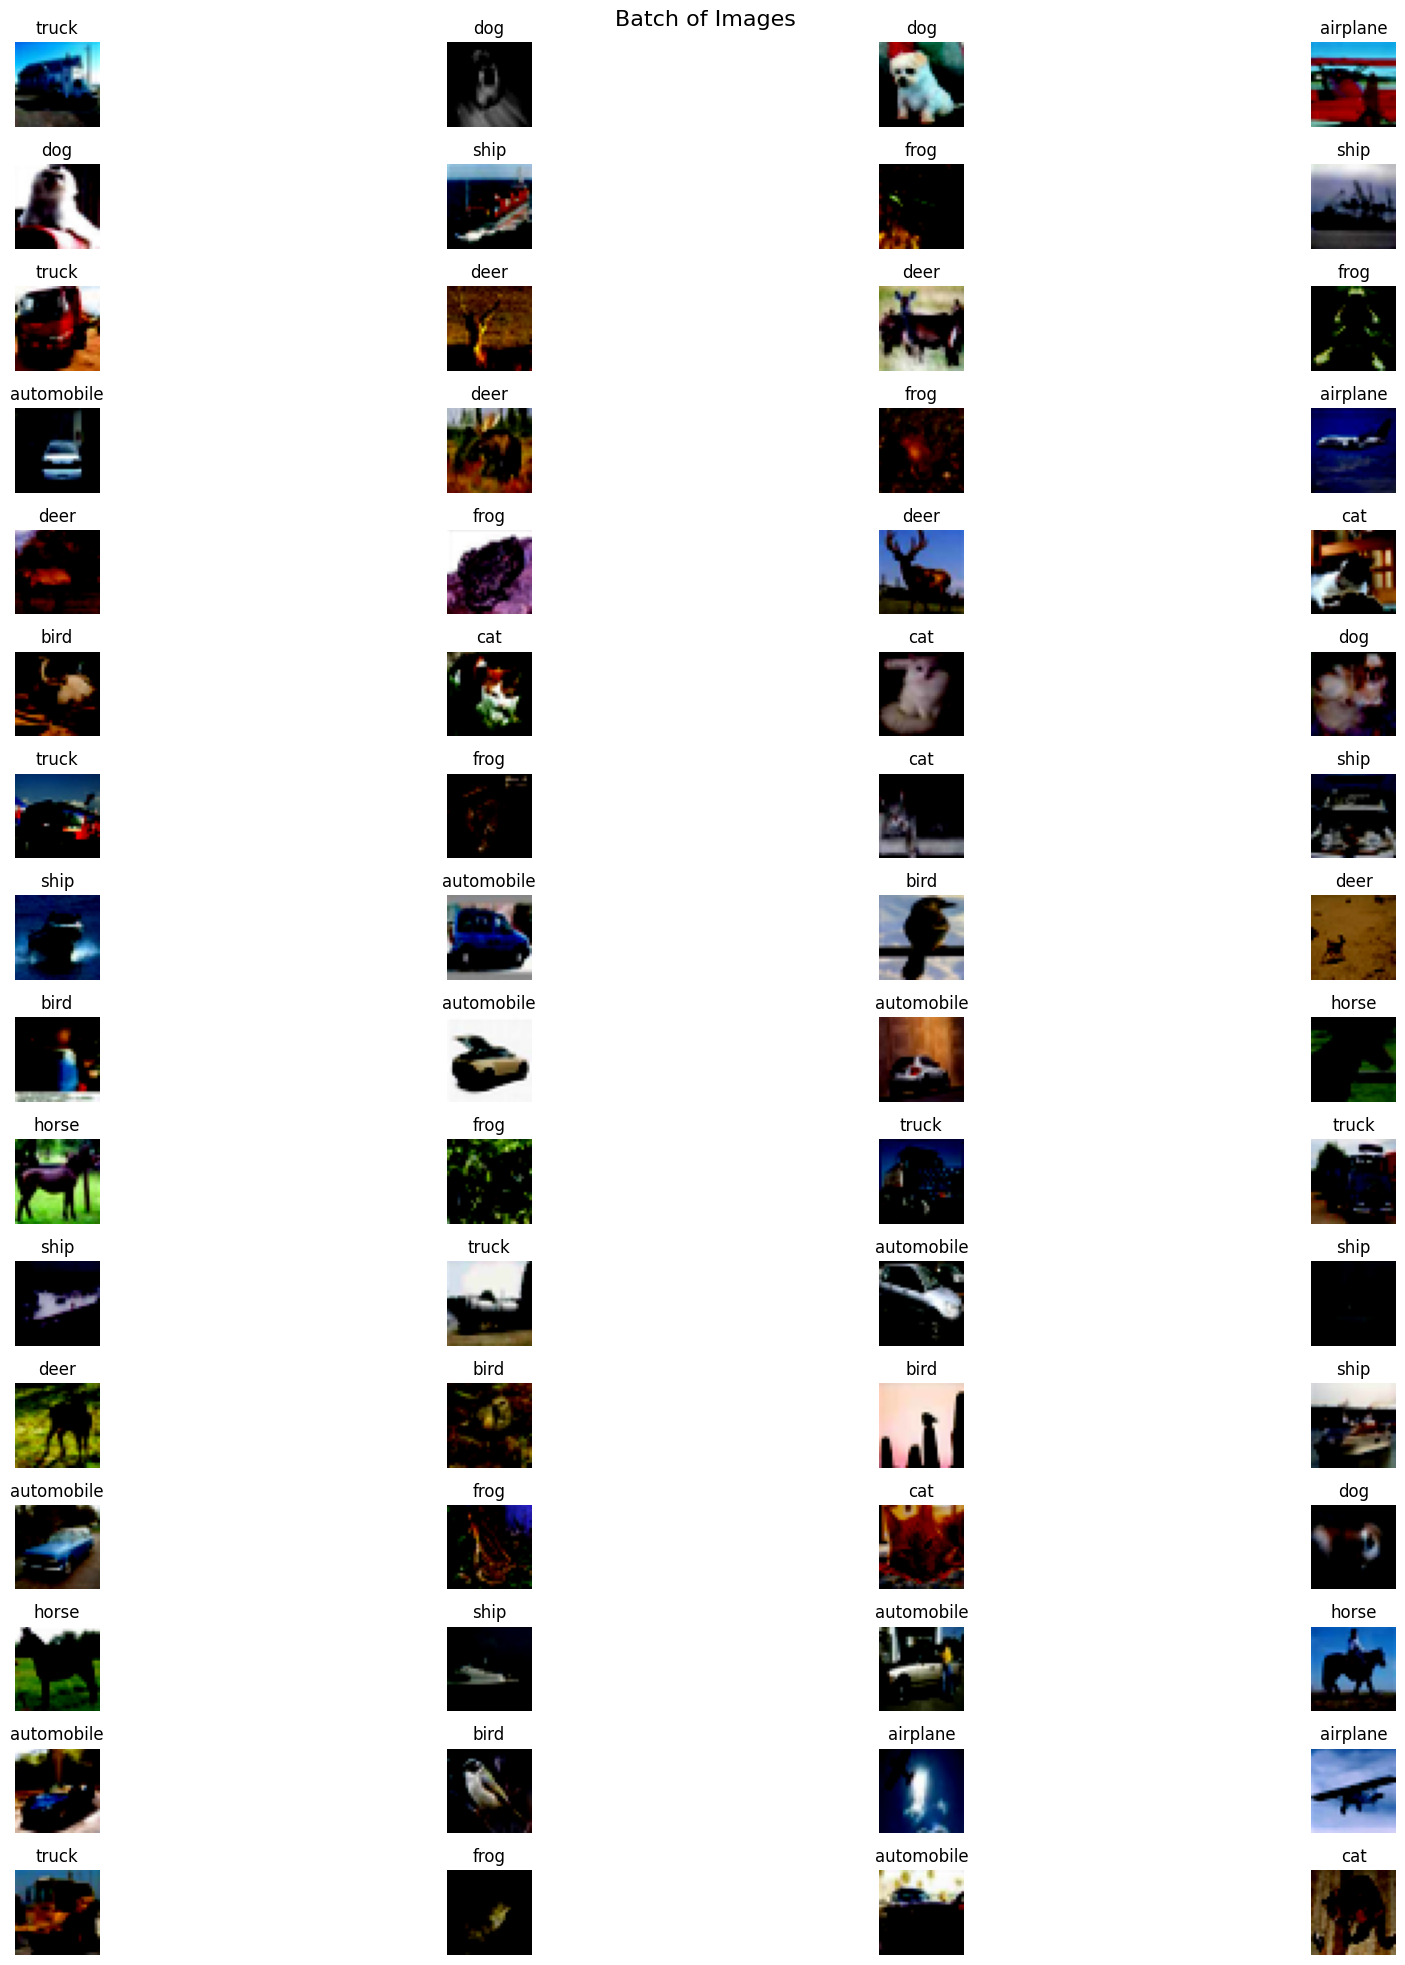

In [8]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# Vizualization of a batch of images
def show_images_batch(images_batch, labels_batch, class_names, nrow, figsize):
    plt.figure(figsize=figsize)
    total_images = len(images_batch)

    for idx in range(total_images):
        plt.subplot(total_images // nrow, nrow, idx + 1)
        plt.imshow(images_batch[idx].permute(1, 2, 0), cmap='binary')
        plt.title(class_names[labels_batch[idx].item()])
        plt.axis('off')

    plt.suptitle('Batch of Images', fontsize=16)
    plt.tight_layout()
    plt.show()



# Example usage:
data_iter = iter(train_loader)
images, labels = next(data_iter)
show_images_batch(images, labels, class_names, nrow=4, figsize=(20, 20))

Now let's check the samples repartition among the different classes

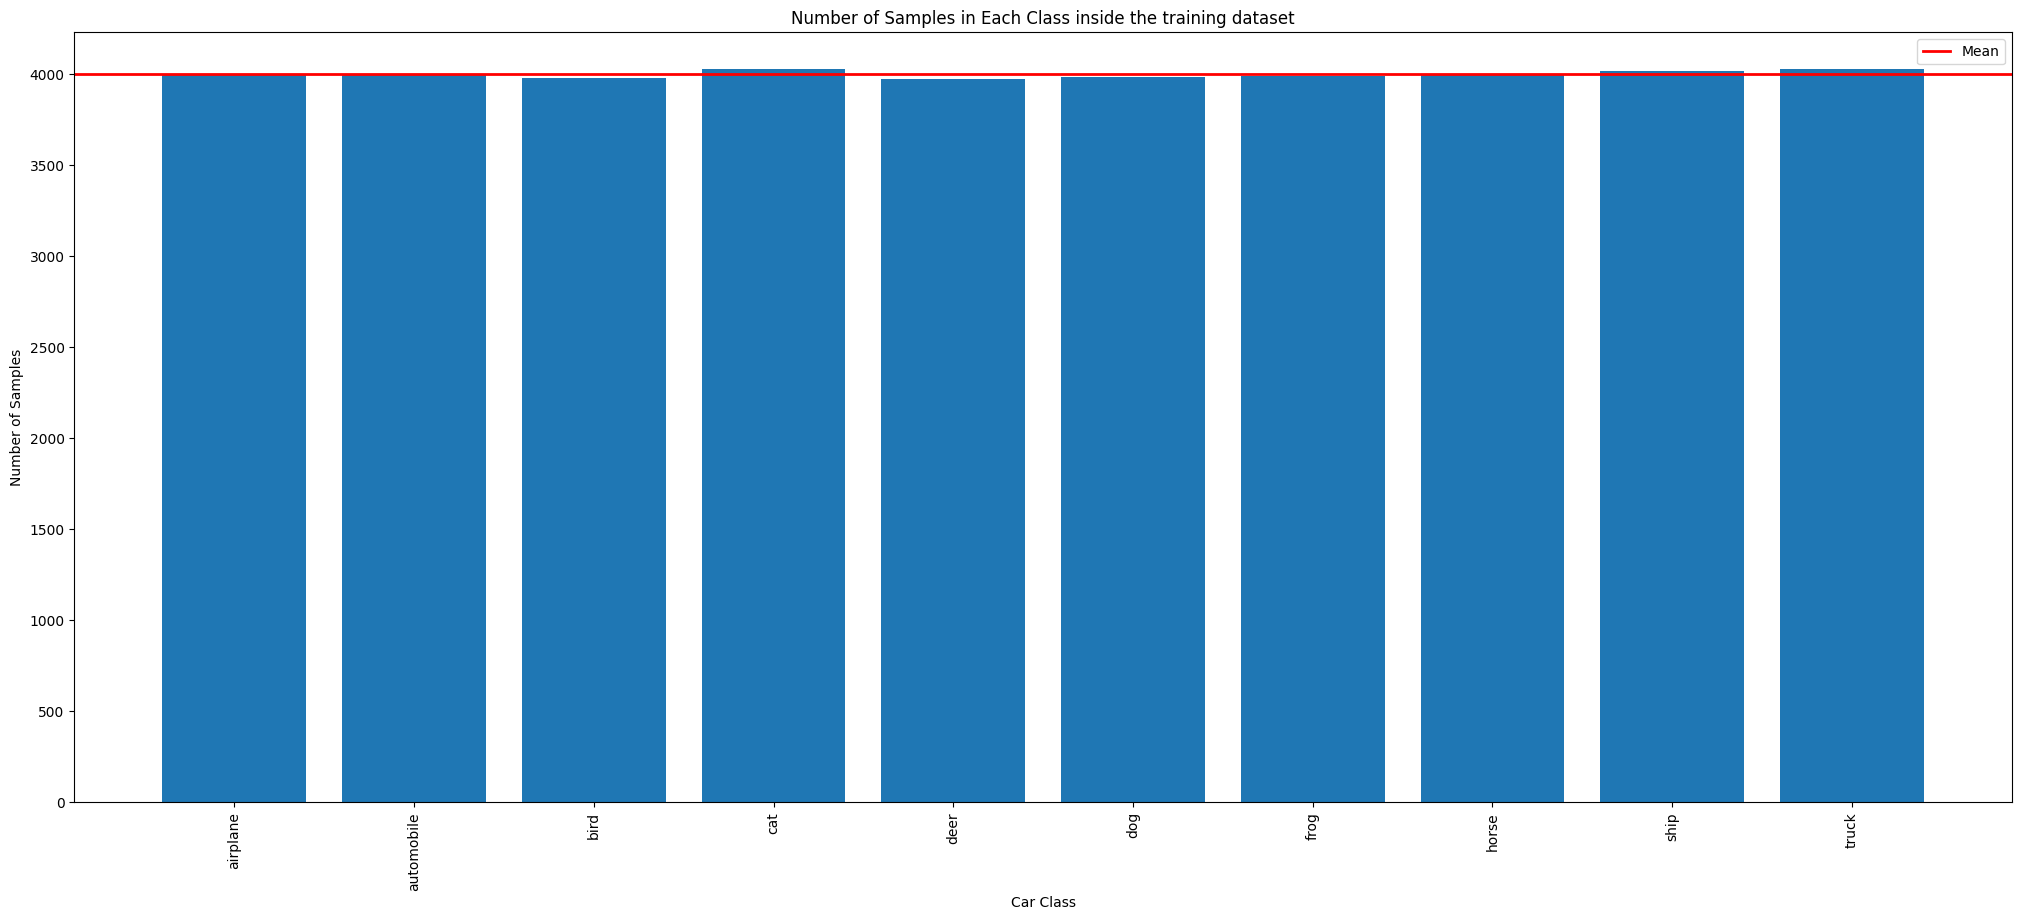

In [9]:
# Function to count samples per class
def count_samples_per_class(data_loader):
    class_count = {key: 0 for key in range(len(class_names))}

    for _, labels in data_loader:
        for label in labels:
            label = label.item()
            class_count[label] += 1

    return class_count

train_class_count = count_samples_per_class(train_loader)

# Visualizing the sample counts for each class
# And calculation of the mean of sample counts per class (red line)
plt.figure(figsize=(25, 10))
plt.bar(class_names, [train_class_count[i] for i in range(len(class_names))])

plt.xlabel('Car Class')
plt.ylabel('Number of Samples')
plt.title('Number of Samples in Each Class inside the training dataset')

mean_value = np.mean(list(train_class_count.values()))
plt.axhline(y=mean_value, color='r', linestyle='-', linewidth=2, label='Mean')
plt.legend()

plt.xticks(rotation=90)
plt.show()

**Discussion:** As we can see, the dataset is almost perfectly balanced. As a result we will not add class weights inside the loss of our future model.

## Defining a simple CNN model

In [10]:
# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = nn.Linear(64 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## Defining the training loop and validation process

We'll define two key functions:

1. **train**: This function trains our model using the training dataset, calculating both accuracy and loss. 

2. **validate**: This function evaluates the model's performance on the validation dataset, calculating both accuracy and loss.

In [11]:
# Define training and validation functions
def train(model, device, train_loader, criterion, optimizer):
    model.train()
    training_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        training_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    acc = correct / total
    loss = training_loss / len(train_loader)
    return loss, acc

## Defining the validation procedure

In [12]:
def validate(model, device, val_loader, criterion):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    loss = val_loss / len(val_loader)
    return loss, acc

## Defining criterion, optimizer and lrscheduler

Here I decided to use common parameters among image classification models.

In [13]:
# Initialize the model, loss function, and optimizer
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleCNN(num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), weight_decay=5e-4, lr=0.001)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=4, min_lr=0.000001, verbose=True)

## Full training process

(The learning rate is dynamically adjusts based on the validation loss)

In [14]:
# Train the model
num_epochs = 25

train_accuracies = []
train_losses = []
val_accuracies = []
val_losses = []
lr_delta = []

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, device, train_loader, criterion, optimizer)
    val_loss, val_accuracy = validate(model, device, val_loader, criterion)
    lrscheduler.step(val_loss)
    lr = optimizer.state_dict()['param_groups'][0]['lr']

    train_accuracies.append(train_accuracy)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    lr_delta.append(lr)

    print(f"Epoch {epoch+1}/{num_epochs}, accuracy: {train_accuracy:.4f}, loss: {train_loss:.4f}, val_accuracy: {val_accuracy:.4f}, val_loss: {val_loss:.4f}, lr: {lr:.6f}")

100%|██████████| 625/625 [00:07<00:00, 87.43it/s] 


Epoch 1/25, accuracy: 0.4702, loss: 1.4580, val_accuracy: 0.5874, val_loss: 1.1511, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 101.16it/s]


Epoch 2/25, accuracy: 0.6064, loss: 1.1155, val_accuracy: 0.6529, val_loss: 0.9899, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 95.44it/s] 


Epoch 3/25, accuracy: 0.6509, loss: 0.9872, val_accuracy: 0.6760, val_loss: 0.9307, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 103.87it/s]


Epoch 4/25, accuracy: 0.6804, loss: 0.9080, val_accuracy: 0.6703, val_loss: 0.9336, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 103.83it/s]


Epoch 5/25, accuracy: 0.7052, loss: 0.8386, val_accuracy: 0.6744, val_loss: 0.9186, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 101.04it/s]


Epoch 6/25, accuracy: 0.7228, loss: 0.7866, val_accuracy: 0.6928, val_loss: 0.8794, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 95.70it/s] 


Epoch 7/25, accuracy: 0.7428, loss: 0.7354, val_accuracy: 0.6953, val_loss: 0.8834, lr: 0.001000


100%|██████████| 625/625 [00:05<00:00, 104.42it/s]


Epoch 8/25, accuracy: 0.7567, loss: 0.6871, val_accuracy: 0.6819, val_loss: 0.9160, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 103.73it/s]


Epoch 9/25, accuracy: 0.7715, loss: 0.6481, val_accuracy: 0.6946, val_loss: 0.8901, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 102.65it/s]


Epoch 10/25, accuracy: 0.7830, loss: 0.6059, val_accuracy: 0.6967, val_loss: 0.8922, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 101.02it/s]


Epoch 11/25, accuracy: 0.7940, loss: 0.5765, val_accuracy: 0.6995, val_loss: 0.8782, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 102.47it/s]


Epoch 12/25, accuracy: 0.8025, loss: 0.5483, val_accuracy: 0.7044, val_loss: 0.8702, lr: 0.001000


100%|██████████| 625/625 [00:05<00:00, 104.74it/s]


Epoch 13/25, accuracy: 0.8180, loss: 0.5141, val_accuracy: 0.6952, val_loss: 0.9141, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 101.67it/s]


Epoch 14/25, accuracy: 0.8220, loss: 0.4959, val_accuracy: 0.7019, val_loss: 0.8834, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 101.62it/s]


Epoch 15/25, accuracy: 0.8304, loss: 0.4746, val_accuracy: 0.6990, val_loss: 0.9205, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 97.97it/s] 


Epoch 16/25, accuracy: 0.8388, loss: 0.4569, val_accuracy: 0.6987, val_loss: 0.9185, lr: 0.001000


100%|██████████| 625/625 [00:06<00:00, 103.11it/s]


Epoch 00017: reducing learning rate of group 0 to 1.0000e-04.
Epoch 17/25, accuracy: 0.8457, loss: 0.4370, val_accuracy: 0.6974, val_loss: 0.9280, lr: 0.000100


100%|██████████| 625/625 [00:06<00:00, 102.05it/s]


Epoch 18/25, accuracy: 0.8971, loss: 0.3011, val_accuracy: 0.7176, val_loss: 0.9292, lr: 0.000100


100%|██████████| 625/625 [00:06<00:00, 102.43it/s]


Epoch 19/25, accuracy: 0.9112, loss: 0.2567, val_accuracy: 0.7204, val_loss: 0.9391, lr: 0.000100


100%|██████████| 625/625 [00:06<00:00, 97.94it/s] 


Epoch 20/25, accuracy: 0.9207, loss: 0.2298, val_accuracy: 0.7217, val_loss: 0.9416, lr: 0.000100


100%|██████████| 625/625 [00:06<00:00, 104.04it/s]


Epoch 21/25, accuracy: 0.9297, loss: 0.2103, val_accuracy: 0.7232, val_loss: 0.9484, lr: 0.000100


100%|██████████| 625/625 [00:06<00:00, 100.79it/s]


Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.
Epoch 22/25, accuracy: 0.9365, loss: 0.1905, val_accuracy: 0.7214, val_loss: 0.9607, lr: 0.000010


100%|██████████| 625/625 [00:06<00:00, 101.71it/s]


Epoch 23/25, accuracy: 0.9443, loss: 0.1723, val_accuracy: 0.7236, val_loss: 0.9637, lr: 0.000010


100%|██████████| 625/625 [00:06<00:00, 96.14it/s] 


Epoch 24/25, accuracy: 0.9455, loss: 0.1677, val_accuracy: 0.7245, val_loss: 0.9652, lr: 0.000010


100%|██████████| 625/625 [00:06<00:00, 103.82it/s]


Epoch 25/25, accuracy: 0.9489, loss: 0.1613, val_accuracy: 0.7235, val_loss: 0.9698, lr: 0.000010


### Visualizing Training and Validation Performance

Let's take a closer look at how our model performed during training and validation. We'll plot two key metrics over epochs:

1. **Training Loss vs. Validation Loss**: This plot helps us monitor the model's convergence and identify overfitting or underfitting.
2. **Training Accuracy vs. Validation Accuracy**: Here, we can see how well our model generalizes to unseen data compared to the training set.

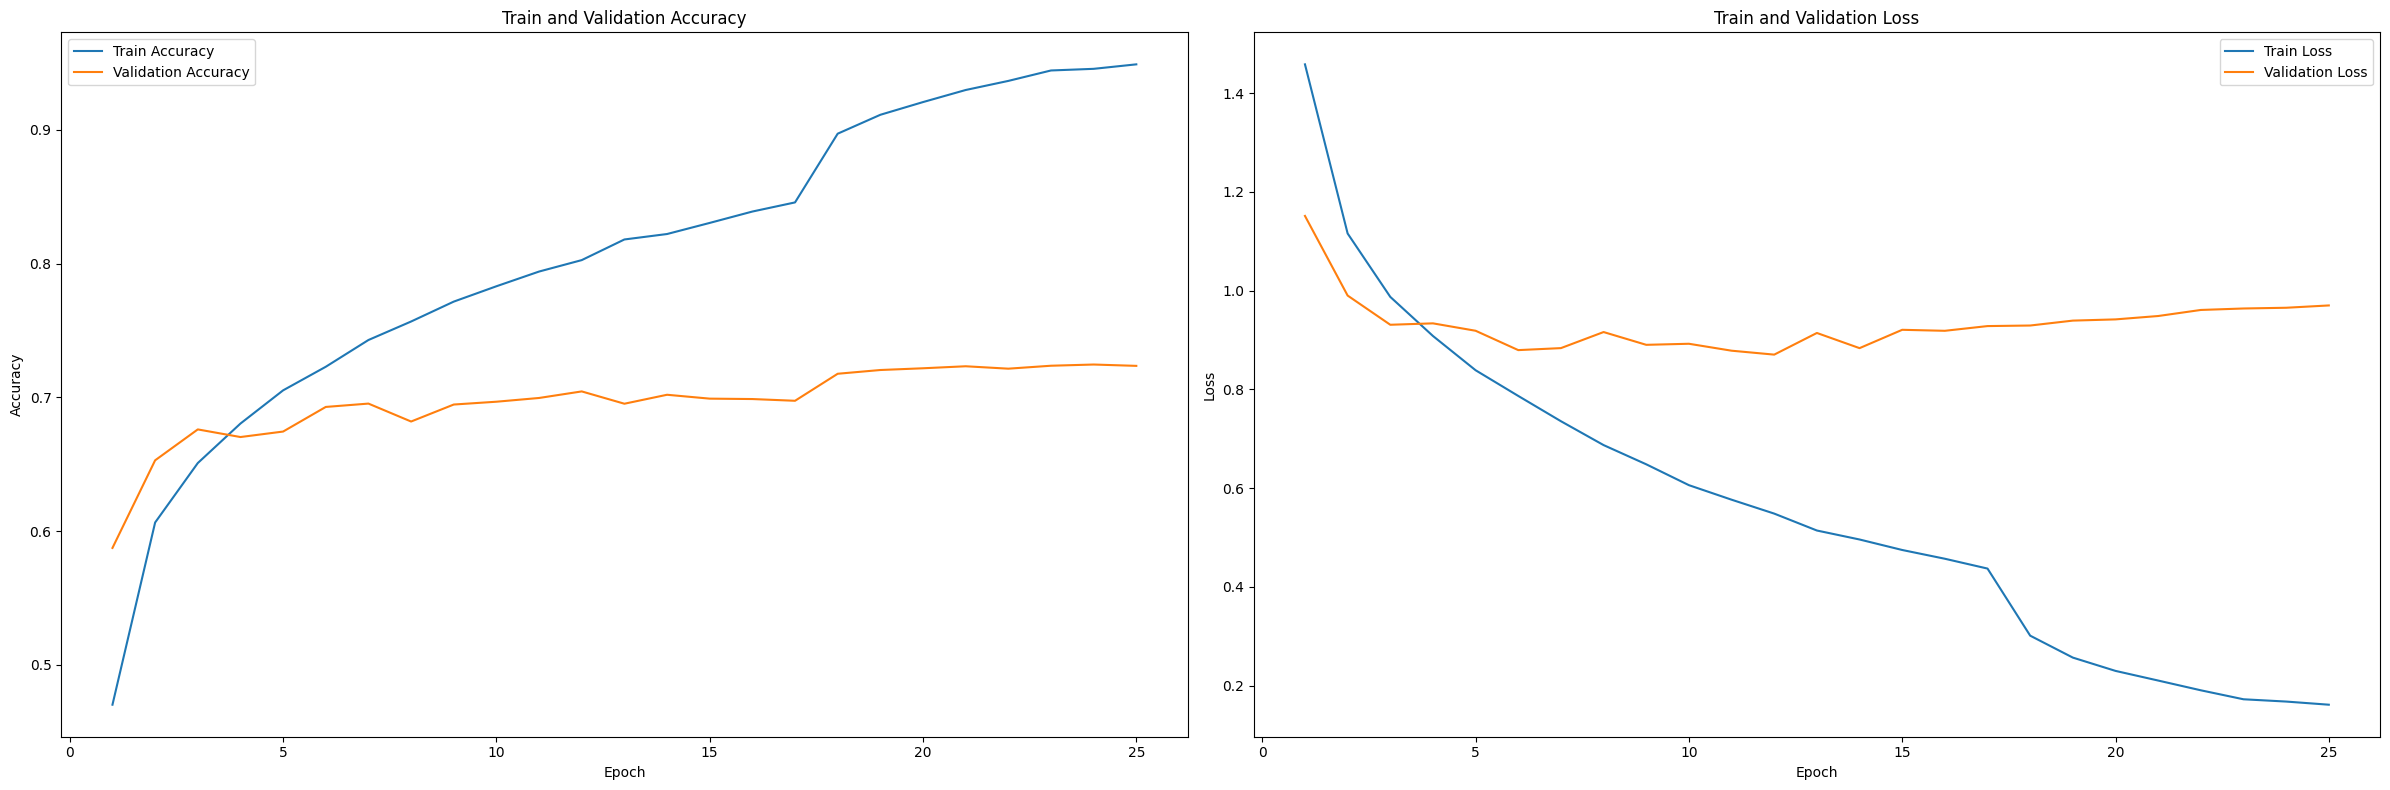

In [15]:
plt.figure(figsize=(24, 8))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')

plt.tight_layout()
plt.show()

## Evaluation of the model

1. **Evaluation**: We set our model to evaluation mode and iterate over the test dataset to make predictions.

2. **Confusion Matrix**: We compute the confusion matrix to understand how well our model is classifying different classes.

3. **Classification Report**: We calculate the final accuracies achieved on the test dataset and print it out for analysis.

In [16]:
# Evaluate the model on the test set
model.eval()
test_loss = 0.0
correct = 0
total = 0

all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        test_loss += loss.item()

        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

test_accuracy = correct / total
test_loss = test_loss / len(test_loader)

print("=== RUNNING ON TEST DATASET ===")
print(f"test_accuracy: {test_accuracy:.2f}, test_loss: {test_loss:.4f}")

=== RUNNING ON TEST DATASET ===
test_accuracy: 0.72, test_loss: 0.9869


### Visualizing Confusion Matrix

Confusion Matrix:


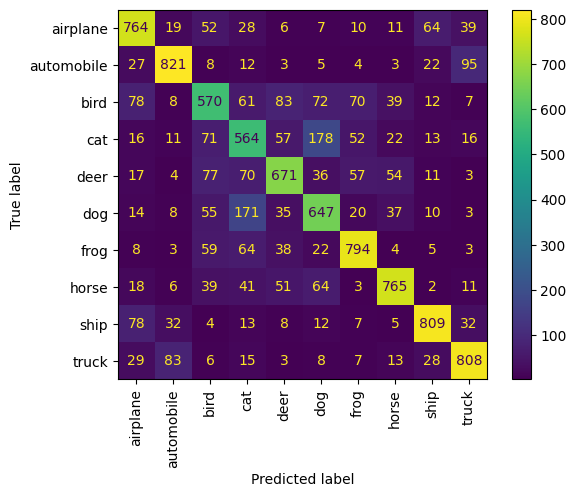

In [17]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(all_labels, all_predictions)

print("Confusion Matrix:")
display_matrix = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=class_names)
display_matrix.plot(cmap=plt.cm.viridis)
plt.xticks(rotation=90)
plt.show()

### Classification Report


In [18]:
class_report = classification_report(all_labels, all_predictions)
print("Classification Report:")
print(class_report)

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.76      0.75      1000
           1       0.83      0.82      0.82      1000
           2       0.61      0.57      0.59      1000
           3       0.54      0.56      0.55      1000
           4       0.70      0.67      0.69      1000
           5       0.62      0.65      0.63      1000
           6       0.78      0.79      0.78      1000
           7       0.80      0.77      0.78      1000
           8       0.83      0.81      0.82      1000
           9       0.79      0.81      0.80      1000

    accuracy                           0.72     10000
   macro avg       0.72      0.72      0.72     10000
weighted avg       0.72      0.72      0.72     10000



## Part II
Now that we have an algorithm running, we need to optimize it.
Let's create a coherent hyperparameter job. Especially by checking out:

* number of layers
* number of neurons

We are going to setup:

* An objectif function
* Search Algorithm

## Import necessary libraries

To find better hyperparameters for our model, we will use Ray.

In [19]:
import ray
from ray import tune
from ray.tune.search.hyperopt import HyperOptSearch
from ray.tune.schedulers import ASHAScheduler
from ray.train import ScalingConfig

2024-06-14 23:27:06,208	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-06-14 23:27:07,282	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [20]:
ray.init(num_gpus=2, num_cpus=4)

2024-06-14 23:27:12,477	INFO worker.py:1724 -- Started a local Ray instance.


Python version:,3.10.13
Ray version:,2.9.0


In [21]:
print(ray.available_resources())

{'memory': 17379058484.0, 'node:172.19.2.2': 1.0, 'node:__internal_head__': 1.0, 'object_store_memory': 8689529241.0, 'GPU': 2.0, 'CPU': 4.0, 'accelerator_type:T4': 1.0}


## Custom CNN

We take the same previous model and add the possibility to manually configure the number of layers and neurons within those layers.

In [22]:
# Define the neural network class
class CustomNet(nn.Module):
    def __init__(self, config):
        super(CustomNet, self).__init__()
        layers = []

        # Layers
        in_channels = 3
        for i in range(1, config["nb_layers"]):
            out_channels = config[f"nb_neurons_layer_{i+1}"]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1))
            layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
            layers.append(nn.MaxPool2d(kernel_size=2, stride=2, padding=0))
            in_channels = out_channels

        self.conv_layers = nn.Sequential(*layers)
        self.flatten = nn.Flatten()

        # Determine the size of the input to the fully connected layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, 32, 32)
            dummy_output = self.conv_layers(dummy_input)
            conv_output_size = dummy_output.view(1, -1).size(1)

        self.fc1 = nn.Linear(conv_output_size, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

## CIFAR-10 Loading and datasets setup

In [23]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# Load the CIFAR10 dataset
full_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))

# Store datasets in the Ray object store
train_dataset_id = ray.put(train_dataset)
val_dataset_id = ray.put(val_dataset)

Files already downloaded and verified
Train dataset size: 40000
Validation dataset size: 10000


## Objective function

Function that will be used by Ray to create and perform a benchmark over different hyperparameters configurations.
(The learning rate is dynamically adjusts based on the validation loss)

In [24]:
# Define the objective function
def objective(config):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    #print(f"Using device: {device}")

    train_dataset = ray.get(train_dataset_id)
    val_dataset = ray.get(val_dataset_id)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = CustomNet(config).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), weight_decay=5e-4, lr=0.001)
    lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',factor=0.1, patience=4, min_lr=0.000001, verbose=True)

    for epoch in tqdm(range(25)):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Evaluate the model
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)

                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        lrscheduler.step(val_loss)

    accuracy = correct / total
    return {"val_accuracy": accuracy, "val_loss": val_loss}

## Hyperparameter space

In [25]:
search_space = {
    "nb_layers": tune.randint(2, 5),
    "nb_neurons_layer_1": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "nb_neurons_layer_2": tune.sample_from(lambda _: 2**np.random.randint(2, 9)),
    "nb_neurons_layer_3": tune.sample_from(lambda _: 2**np.random.randint(2, 9)), # Might not be used
    "nb_neurons_layer_4": tune.sample_from(lambda _: 2**np.random.randint(2, 9)), # Might not be used
    "nb_neurons_layer_5": tune.sample_from(lambda _: 2**np.random.randint(2, 9)) # Might not be used
}

algo = HyperOptSearch()

## Models training and Benchmark

We use the tune function with_resouces to train our model on the 2 Kaggle GPUs. Models are run two at a time, with each model utilizing one GPU and two CPUs.

In [26]:
# Run the hyperparameter search
tuner = tune.Tuner(
    tune.with_resources(objective, {"cpu": 2, "gpu": 1}),
    tune_config=tune.TuneConfig(
        metric="val_accuracy",
        mode="max",
        search_alg=algo,
        num_samples=40
    ),
    param_space=search_space
)
results = tuner.fit()

 76%|███████▌  | 19/25 [04:17<01:20, 13.44s/it]


(objective pid=1906) Epoch 00019: reducing learning rate of group 0 to 1.0000e-04.


 96%|█████████▌| 24/25 [05:24<00:13, 13.37s/it]
2024-06-14 23:33:03,487	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  0%|          | 0/25 [00:00<?, ?it/s]
2024-06-14 23:33:15,336	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 52%|█████▏    | 13/25 [02:47<02:34, 12.90s/it]


(objective pid=1873) Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


 88%|████████▊ | 22/25 [04:44<00:38, 12.91s/it]


(objective pid=1906) Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 25/25 [05:09<00:00, 12.38s/it]
2024-06-14 23:38:13,277	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  4%|▍         | 1/25 [00:12<05:07, 12.82s/it]
2024-06-14 23:38:39,308	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 60%|██████    | 15/25 [03:13<02:09, 12.99s/it]


(objective pid=1906) Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


 80%|████████  | 20/25 [04:19<01:05, 13.03s/it]


(objective pid=1873) Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


 84%|████████▍ | 21/25 [04:32<00:52, 13.02s/it]


(objective pid=1906) Epoch 00021: reducing learning rate of group 0 to 1.0000e-05.


 88%|████████▊ | 22/25 [04:45<00:39, 13.16s/it]
2024-06-14 23:43:32,265	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  8%|▊         | 2/25 [00:26<05:08, 13.42s/it]
2024-06-14 23:44:03,749	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
100%|██████████| 25/25 [05:30<00:00, 13.21s/it]
2024-06-14 23:49:02,870	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neuro

(objective pid=1906) Epoch 00020: reducing learning rate of group 0 to 1.0000e-04.


 92%|█████████▏| 23/25 [04:56<00:25, 12.89s/it]
2024-06-14 23:54:31,435	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
100%|██████████| 25/25 [05:21<00:00, 12.87s/it]
2024-06-14 23:54:53,107	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
100%|██████████| 25/25 [05:29<00:00, 13.20s/it] [repeated 2x across cluster]
2024-06-15 00:00:01,864	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logg

(objective pid=1873) Epoch 00018: reducing learning rate of group 0 to 1.0000e-04.


 92%|█████████▏| 23/25 [04:55<00:25, 12.85s/it]


(objective pid=1873) Epoch 00023: reducing learning rate of group 0 to 1.0000e-05.


 96%|█████████▌| 24/25 [05:17<00:13, 13.12s/it]
2024-06-15 00:05:26,105	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  0%|          | 0/25 [00:00<?, ?it/s]
2024-06-15 00:05:32,118	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 88%|████████▊ | 22/25 [04:37<00:38, 12.72s/it] [repeated 2x across cluster]


(objective pid=1906) Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


 96%|█████████▌| 24/25 [05:02<00:12, 12.64s/it] [repeated 2x across cluster]
2024-06-15 00:10:41,806	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  0%|          | 0/25 [00:00<?, ?it/s]
2024-06-15 00:10:43,490	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 96%|█████████▌| 24/25 [05:21<00:13, 13.30s/it]
2024-06-15 00:16:13,005	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to te

(objective pid=1873) Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


 92%|█████████▏| 23/25 [05:05<00:26, 13.31s/it]


(objective pid=1906) Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.
(objective pid=1873) Epoch 00022: reducing learning rate of group 0 to 1.0000e-05.


 92%|█████████▏| 23/25 [05:12<00:27, 13.53s/it]
2024-06-15 00:27:14,377	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  4%|▍         | 1/25 [00:12<05:05, 12.71s/it]
2024-06-15 00:27:33,959	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 64%|██████▍   | 16/25 [03:32<01:59, 13.29s/it]


(objective pid=1873) Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


 88%|████████▊ | 22/25 [04:49<00:39, 13.00s/it]


(objective pid=1873) Epoch 00021: reducing learning rate of group 0 to 1.0000e-05.


 92%|█████████▏| 23/25 [05:09<00:26, 13.18s/it]
2024-06-15 00:32:43,457	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
100%|██████████| 25/25 [05:35<00:00, 13.42s/it]
2024-06-15 00:33:09,879	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 56%|█████▌    | 14/25 [03:04<02:24, 13.13s/it]


(objective pid=1906) Epoch 00014: reducing learning rate of group 0 to 1.0000e-04.


 80%|████████  | 20/25 [04:23<01:06, 13.25s/it]


(objective pid=1906) Epoch 00020: reducing learning rate of group 0 to 1.0000e-05.


 96%|█████████▌| 24/25 [05:17<00:13, 13.35s/it]


(objective pid=1873) Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 25/25 [05:31<00:00, 13.25s/it]
2024-06-15 00:38:15,004	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}


(objective pid=1906) Epoch 00025: reducing learning rate of group 0 to 1.0000e-06.


  8%|▊         | 2/25 [00:24<04:43, 12.33s/it]
2024-06-15 00:38:46,948	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 72%|███████▏  | 18/25 [03:58<01:32, 13.23s/it]


(objective pid=1906) Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


 84%|████████▍ | 21/25 [04:37<00:52, 13.19s/it]
2024-06-15 00:43:27,397	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  8%|▊         | 2/25 [00:25<04:53, 12.75s/it]


(objective pid=1873) Epoch 00024: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 25/25 [05:30<00:00, 13.22s/it]
2024-06-15 00:44:17,872	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 84%|████████▍ | 21/25 [04:27<00:51, 12.78s/it]
2024-06-15 00:48:46,350	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 12%|█▏        | 3/25 [00:39<04:50, 13.21s/it]
2024-06-15 00:49:36,844	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neuro

(objective pid=1873) Epoch 00015: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 25/25 [05:25<00:00, 13.01s/it]
2024-06-15 00:54:11,990	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  0%|          | 0/25 [00:00<?, ?it/s]


(objective pid=1873) Epoch 00021: reducing learning rate of group 0 to 1.0000e-05.


100%|██████████| 25/25 [05:28<00:00, 13.15s/it]
2024-06-15 00:55:06,023	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
100%|██████████| 25/25 [05:50<00:00, 14.01s/it]
2024-06-15 01:00:02,840	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
  8%|▊         | 2/25 [00:25<04:51, 12.69s/it]
2024-06-15 01:00:32,049	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neuro

(objective pid=1873) Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 25/25 [05:27<00:00, 13.11s/it]
2024-06-15 01:06:00,255	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 84%|████████▍ | 21/25 [04:33<00:51, 12.93s/it]
2024-06-15 01:10:47,307	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
100%|██████████| 25/25 [05:25<00:00, 13.04s/it]


(objective pid=1873) Epoch 00022: reducing learning rate of group 0 to 1.0000e-04.


100%|██████████| 25/25 [05:25<00:00, 13.02s/it]
2024-06-15 01:11:26,161	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 92%|█████████▏| 23/25 [04:59<00:26, 13.03s/it]


(objective pid=1906) Epoch 00023: reducing learning rate of group 0 to 1.0000e-04.


 84%|████████▍ | 21/25 [04:37<00:52, 13.22s/it]
2024-06-15 01:16:12,924	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
 96%|█████████▌| 24/25 [05:07<00:10, 10.96s/it]
2024-06-15 01:16:42,705	INFO tensorboardx.py:275 -- Removed the following hyperparameter values when logging to tensorboard: {'nb_neurons_layer_1': ('__fn_ph', '7dc0a33a'), 'nb_neurons_layer_2': ('__fn_ph', '2d75c4c8'), 'nb_neurons_layer_3': ('__fn_ph', '27c8bce1'), 'nb_neurons_layer_4': ('__fn_ph', '5ca62185'), 'nb_neurons_layer_5': ('__fn_ph', 'd81b9c6a')}
2024-06-15 01:16:42,738	INFO tune.py:1042 -- Total run time: 6565.21 seconds (6557.43 seconds for the tuning loop).
100%|██████████| 25/25 [05:16<00:00, 12.65s/it]


## Results

In [27]:
# Print the best result
print("Best hyperparameters found were: ", results.get_best_result().config)

Best hyperparameters found were:  {'nb_layers': 4, 'nb_neurons_layer_1': 4, 'nb_neurons_layer_2': 32, 'nb_neurons_layer_3': 256, 'nb_neurons_layer_4': 128, 'nb_neurons_layer_5': 16}


With this configuration, we won 10% accuracy to reach 0.8283!

In [28]:
ray.shutdown()